In [1]:
!pip install tqdm
!pip install nltk
!pip install tensorflow
!pip install gensim
!pip install bz2file

You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
import pandas as pd
import bz2
import numpy as np 
import re
import nltk
import gensim.models.word2vec as word2vec
import tqdm
import multiprocessing
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# existe uma api do proprio kaggle para download de seus datasets, entretanto é preciso configuracao de credencial 
# oque nao seria viavel dentro de um notebook, pedimos entao que por favor faça o download do dataset e bote na
# pasta do projeto

# https://www.kaggle.com/bittlingmayer/amazonreviews/downloads/amazonreviews.zip/2

import zipfile
zip_ref = zipfile.ZipFile('amazonreviews.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
train_file = bz2.BZ2File('train.ft.txt.bz2')
test_file = bz2.BZ2File('test.ft.txt.bz2')

In [5]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [6]:
train_file_lines[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

Utilizamos um tamanho reduzido do dataset devido ao altissimo valor de memoria allocada e tempo de processamento para o dataset completo

In [8]:
temp = []
corpus_raw = u""
for line in tqdm.tqdm(train_file_lines[:500000]):
    text = re.sub('__label__', '', line)
    sentiment = int(text[0]) - 1
    clean_text = re.sub("[^a-zA-Z]"," ", text[1:])
    
    corpus_raw += text[1:]
    
    temp.append([clean_text, sentiment])

 80%|███████▉  | 399118/500000 [00:09<00:02, 39973.68it/s]/home/pedalv/miniconda3/envs/jupyter/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 500000/500000 [00:13<00:00, 38093.57it/s]


In [9]:
df = pd.DataFrame(temp, columns=['Review', 'Sentiment'])
df.head()

,Review,Sentiment
0,Stuning even for the non gamer This sound tr...,1
1,The best soundtrack ever to anything I m re...,1
2,Amazing This soundtrack is my favorite musi...,1
3,Excellent Soundtrack I truly like this sound...,1
4,Remember Pull Your Jaw Off The Floor After H...,1


Conferimos se nosso dataset se encontra balanceado, ou seja, um numero similar entre reviews negativos e positivos

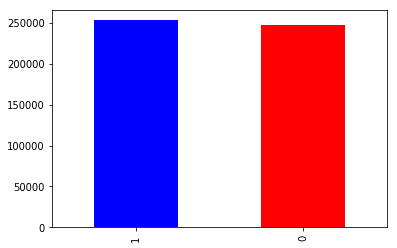

In [10]:
df['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'])

In [11]:
df.describe()

,Sentiment
count,500000.000000
mean,0.505564
std,0.499970
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# Train Word2Vec

O word2vec vetoriza cada palavra do corpus levando em consideração o contexto no qual é usada, deste modo palavras de contexto parecidos são espacialmente próximas

In [12]:
corpus_raw[0:400]

' Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyo'

Precisamos separar as sentecas para que nosso modelo Word2Vec entenda o contexto das palavras

In [13]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw)
del corpus_raw

In [14]:
len(raw_sentences)

2442780

In [15]:
raw_sentences[0:2]

[' Stuning even for the non-gamer: This sound track was beautiful!',
 'It paints the senery in your mind so well I would recomend it even to people who hate vid.']

Vamos fazer uma função para gerar uma lista de palavras para o input de nosso modelo de Word2Vec e para limpar o texto de tudo que não seja palavra, como por exemplo pontuação e números

In [16]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [17]:
sentences = []

for raw_sentence in tqdm.tqdm(raw_sentences):
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        
del raw_sentences
print(sentences[0:2])

 52%|█████▏    | 1272601/2442780 [00:09<00:09, 127577.19it/s]/home/pedalv/miniconda3/envs/jupyter/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 2442780/2442780 [00:19<00:00, 128443.61it/s]

[['Stuning', 'even', 'for', 'the', 'non', 'gamer', 'This', 'sound', 'track', 'was', 'beautiful'], ['It', 'paints', 'the', 'senery', 'in', 'your', 'mind', 'so', 'well', 'I', 'would', 'recomend', 'it', 'even', 'to', 'people', 'who', 'hate', 'vid']]


In [18]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 40,763,261 tokens


In [19]:
# quantidade de features para cada palavra
num_features = 50

In [20]:
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3

word2vec_model = word2vec.Word2Vec(
    sg=1,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

word2vec_model.build_vocab(sentences)

In [21]:
print("Word2Vec vocabulary length:", word2vec_model.corpus_count)

Word2Vec vocabulary length: 2442780


In [22]:
word2vec_model.train(sentences=sentences, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

(155756008, 203816305)

Para evitar perda de tempo futuramente, salvamos o modelo treinado

In [ ]:
if not os.path.exists("trained"):
    os.makedirs("trained")

word2vec_model.save(os.path.join("trained", "word2vec.w2v"))

# Load Word2Vec

Caso já exista um modelo localmente, não existe a necessidade de um novo treinamento

In [23]:
word2vec_model = word2vec.Word2Vec.load(os.path.join("trained", "word2vec.w2v"))

Uma grande vantagem em utilizar o Word2Vec é que palavras que são utilizadas em contextos parecidos sem encontram espacialmente próximas, para confirmar isso veremos a similaridade de algumas palavras 

In [27]:
# vamos plotar um tamanho com o numero reduzido de palavras para facilitar a visualizacao
vocab = list(word2vec_model.wv.vocab)
plotX = word2vec_model.wv[vocab[:200]]

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(plotX)

In [30]:
plot_df = pd.DataFrame(X_tsne, index=vocab[:200], columns=['x', 'y'])

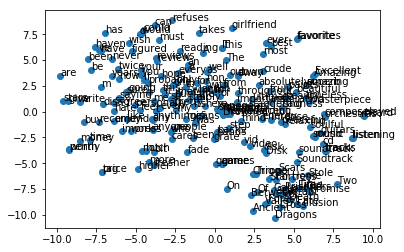

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(plot_df['x'], plot_df['y'])
for word, pos in plot_df.iterrows():
    ax.annotate(word, pos)

é possivel visualizar no canto superior esquerdo que has se encontra próximo de have, oque faz sentido

In [24]:
word2vec_model.wv.most_similar("religion")

[('religious', 0.9126484990119934),
 ('feminism', 0.8984538316726685),
 ('beliefs', 0.8751451969146729),
 ('philosophy', 0.8727445602416992),
 ('Judaism', 0.8704853057861328),
 ('Christianity', 0.8699238300323486),
 ('pagan', 0.8640955686569214),
 ('polygamy', 0.8609815835952759),
 ('dogma', 0.8601607084274292),
 ('christianity', 0.8583727478981018)]

In [25]:
word2vec_model.wv.most_similar("good")

[('great', 0.9000533819198608),
 ('decent', 0.8518530130386353),
 ('geat', 0.8289124369621277),
 ('ok', 0.8229893445968628),
 ('iffy', 0.8221654891967773),
 ('gret', 0.8092708587646484),
 ('okay', 0.8062528371810913),
 ('grat', 0.8022298812866211),
 ('nice', 0.8007925748825073),
 ('goog', 0.7991256713867188)]

In [26]:
word2vec_model.wv.most_similar("bad")

[('horrible', 0.8662967681884766),
 ('terrible', 0.8544621467590332),
 ('awful', 0.8308203816413879),
 ('horrable', 0.8215155601501465),
 ('sucky', 0.819815993309021),
 ('lousy', 0.8187485933303833),
 ('dumb', 0.8101130127906799),
 ('crappy', 0.802151083946228),
 ('stupid', 0.8013467192649841),
 ('terriable', 0.8011031150817871)]

# Model Preparation

Aqui vamos tokenizar as palavras de nosso dataset, ou seja, dar um id unico para cada palavra, para podermos substituir pelo vetor de features correspondente

In [13]:
import tensorflow as tf

In [17]:
max_words = 200000
n_features = 50
n_classes = 2

In [59]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Review'].astype(str))

sequence = tokenizer.texts_to_sequences(df['Review'].astype(str))

In [60]:
df["Token"] = sequence
df.head()

,Review,Sentiment,Token
0,Stuning even for the non gamer This sound tr...,1,"[51986, 75, 11, 1, 631, 8543, 8, 180, 440, 13,..."
1,The best soundtrack ever to anything I m re...,1,"[1, 80, 964, 115, 5, 252, 2, 100, 139, 4, 173,..."
2,Amazing This soundtrack is my favorite musi...,1,"[313, 8, 964, 9, 23, 261, 114, 7, 28, 56, 841,..."
3,Excellent Soundtrack I truly like this sound...,1,"[186, 964, 2, 421, 31, 8, 964, 3, 2, 259, 300,..."
4,Remember Pull Your Jaw Off The Floor After H...,1,"[564, 1238, 63, 8065, 134, 1, 1404, 86, 1118, ..."


In [20]:
vocab_size = min(max_words, len(tokenizer.word_index))+1

embedding_matrix = np.zeros((vocab_size, n_features)).astype(np.float32)
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv[word]

In [21]:
def get_input_features(sentence):
    sentence_word_ids = np.array([x for x in sentence])

    n_words = len(sentence)        
    sentence_word_ids = sentence_word_ids.reshape((n_words,1))
    
    return sentence_word_ids


# Model


A LSTM foi utilizada por 2 principais motivos. O primeiro diz respeito ao fato de LSTM ser uma RNN, o que permite uma entrada de tamanho variável, o que é perfeito para tratar perguntas de tamanhos diferentes. O segundo motivo, e mais importante, é o fato da LSTM guardar uma memória do que foi previamente passado como input, ou seja, a ordem das palavras importa, ‘cachorro mordeu o homem’ não é igual a ‘homem mordeu o cachorro’. 

Para esse modelo em específico estamos usando um BiLSTM(LSTM bidireconal), ou seja, 2 LSTMs, uma sendo alimentada do inicio da frase até o final('the', 'dog', 'is', 'blue') e outra sendo allimentada do final até o inicio(blue, is, the, dog)

A BiLSTM é um metodo muito conhecido para NLP, vários modelos que são estado da arte em tarefas compartilhadas de NLP a utilizam, como por exemplo o chunking.


In [180]:
tf.reset_default_graph()

t_state = tf.placeholder(tf.int32)

# índices das palavras
t_x_words = tf.placeholder(tf.int32, shape=(None,1))

hidden_features = 100
mid = 30

# geramos os paramteros do modelo
with tf.variable_scope("model"):
    # parâmetros de embedding
    t_embedding = tf.convert_to_tensor(embedding_matrix)
    
    # parâmetros da camada escondida
    t_W_mid = tf.Variable(np.random.normal(0,1.0/np.sqrt(mid),(hidden_features,mid)).astype(np.float32))
    t_b_mid = tf.Variable(np.zeros(mid).astype(np.float32))
    
    # parâmetros que computam 0 sentimento
    t_W_out = tf.Variable(np.random.normal(0,1.0/np.sqrt(hidden_features),
                                          (mid, n_classes)).astype(np.float32))
    t_b_out = tf.Variable(np.zeros((1, n_classes)).astype(np.float32))

# Recuperamos os embeddings de cada palavra
t_word_features = tf.gather_nd(t_embedding, t_x_words)


### RNN
lstmcellf = tf.nn.rnn_cell.LSTMCell(num_units=hidden_features/2, state_is_tuple=True)
lstmcellb = tf.nn.rnn_cell.LSTMCell(num_units=hidden_features/2, state_is_tuple=True)

with tf.variable_scope("Bilstm"):
    state_size = hidden_features
    
    t_tok_features_shp = tf.reshape(t_word_features,(1, t_state, n_features))

    h1, last_states =tf.nn.bidirectional_dynamic_rnn(
        cell_fw=lstmcellf,
        cell_bw=lstmcellb,
        dtype=tf.float32,
        inputs=t_tok_features_shp)

    t_hidden = tf.concat((h1[0][0],h1[1][0]),axis=1)
    
t_scores_mid = tf.nn.relu(tf.matmul(t_hidden, t_W_mid) + t_b_mid)
t_score = tf.reduce_sum(t_scores_mid, axis=0)

t_score = tf.expand_dims(t_score, 0)

t_out = tf.matmul(t_score, t_W_out) + t_b_out

# índices corretos das classes dos intervalos corretos
t_y_class = tf.placeholder(tf.int32)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(t_y_class, n_classes), 
                                                              logits=t_out))

# # gradiente descendente no custo
optimizer = tf.train.AdamOptimizer().minimize(loss)

Vamos fazer agora uma função para prever o sentimento de uma review

In [181]:
def pred(sess,x_words):
    pred = sess.run(t_out, feed_dict={
        t_state:len(x_words),
        t_x_words:x_words,
    })
    
    return np.argmax(pred, axis=1)[0]

In [182]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

pred(sess, x_words)

0

Vamos dividir o dataset entre treino e teste

In [183]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df.Token, df.Sentiment, test_size = 0.1, random_state = 0)

In [184]:
def pred_validation(X, Y):
    preds = []
    
    for sentence_id in tqdm.tqdm(np.arange(len(X))):
        x_words = get_input_features(X[sentence_id])
        preds.append(pred(sess, x_words))

    return np.mean(Y == preds)

Vamos treinar o modelo em uma pequena porcentagem do dataset, para conferir se ele esta aprendendo

In [188]:
import tqdm

sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epochs = 20

for epoch in range(n_epochs):
    preds = []
    for sentence_id in tqdm.tqdm(np.arange(len(X_test.values[:500]))):
        x_words = get_input_features(X_test.values[sentence_id])
        y_class = Y_test.values[sentence_id]
        
        _, epoch_pred = sess.run([optimizer, t_out], feed_dict={
            t_state:len(x_words),
            t_x_words:x_words,
            t_y_class:y_class})
        
        preds.append(np.argmax(epoch_pred, axis=1)[0])
    print(np.mean(Y_test.values[:500] == preds))

100%|██████████| 500/500 [00:05<00:00, 91.38it/s]


0.568


100%|██████████| 500/500 [00:05<00:00, 87.42it/s]


0.684


100%|██████████| 500/500 [00:05<00:00, 92.82it/s]


0.762


100%|██████████| 500/500 [00:05<00:00, 92.35it/s]


0.822


100%|██████████| 500/500 [00:05<00:00, 96.05it/s]


0.846


100%|██████████| 500/500 [00:05<00:00, 92.25it/s] 


0.86


100%|██████████| 500/500 [00:05<00:00, 92.25it/s]


0.868


100%|██████████| 500/500 [00:05<00:00, 90.86it/s]


0.884


100%|██████████| 500/500 [00:05<00:00, 95.38it/s] 


0.892


100%|██████████| 500/500 [00:05<00:00, 91.22it/s]


0.906


100%|██████████| 500/500 [00:05<00:00, 90.37it/s]


0.916


100%|██████████| 500/500 [00:05<00:00, 97.15it/s] 


0.934


100%|██████████| 500/500 [00:05<00:00, 92.01it/s]


0.93


100%|██████████| 500/500 [00:05<00:00, 89.81it/s]


0.94


100%|██████████| 500/500 [00:05<00:00, 98.87it/s] 


0.942


100%|██████████| 500/500 [00:05<00:00, 93.72it/s] 


0.95


100%|██████████| 500/500 [00:05<00:00, 92.32it/s] 


0.964


100%|██████████| 500/500 [00:05<00:00, 94.37it/s]


0.966


100%|██████████| 500/500 [00:05<00:00, 83.49it/s]


0.964


100%|██████████| 500/500 [00:05<00:00, 92.76it/s]


0.95


Podemos ver que o modelo esta de fato aprendendo, uma vez que a acuracia sobe com o passar das epocas e vai se aproximando do 100%

## Training on full training samples

Agora utilizamos o dataset inteiro para o resultado real

In [193]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epochs = 10
best = 0

saver = tf.train.Saver()

for epoch in range(n_epochs):
    preds = []
    for sentence_id in tqdm.tqdm(np.arange(len(X_train))):
        x_words = get_input_features(X_train.values[sentence_id])
        y_class = Y_train.values[sentence_id]
        
        _, epoch_pred = sess.run([optimizer, t_out], feed_dict={
            t_state:len(x_words),
            t_x_words:x_words,
            t_y_class:y_class})
        
        preds.append(np.argmax(epoch_pred, axis=1)[0])
    train_acc = np.mean(Y_train.values == preds)
    acc = pred_validation(X_test.values, Y_test.values)
    print('Train acc: {}  Validation acc: {}'.format(train_acc, acc))
    
    if acc > best:
        best = acc
        save_path = saver.save(sess, "/tmp/model.ckpt")
    

  0%|          | 950/450000 [00:09<1:18:34, 95.25it/s]/home/pedalv/miniconda3/envs/jupyter/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 50000/50000 [02:58<00:00, 279.52it/s]


Train acc: 0.9198444444444445  Validation acc: 0.92796


100%|██████████| 50000/50000 [02:56<00:00, 283.07it/s]


Train acc: 0.9333466666666667  Validation acc: 0.93102


100%|██████████| 50000/50000 [02:56<00:00, 282.62it/s]


Train acc: 0.9362466666666667  Validation acc: 0.93334


100%|██████████| 50000/50000 [02:56<00:00, 282.66it/s]


Train acc: 0.9373844444444445  Validation acc: 0.93638


  0%|          | 10/450000 [00:00<1:21:20, 92.21it/s]

Train acc: 0.9380644444444445  Validation acc: 0.93496


  0%|          | 10/450000 [00:00<1:21:22, 92.17it/s]

Train acc: 0.9383511111111111  Validation acc: 0.93402


  0%|          | 10/450000 [00:00<1:23:18, 90.03it/s]

Train acc: 0.9387022222222222  Validation acc: 0.93502


  0%|          | 9/450000 [00:00<1:25:41, 87.52it/s]

Train acc: 0.9387244444444445  Validation acc: 0.93508


  0%|          | 10/450000 [00:00<1:23:54, 89.38it/s]

Train acc: 0.93826  Validation acc: 0.9272


100%|██████████| 50000/50000 [02:57<00:00, 281.96it/s]

Train acc: 0.9380111111111111  Validation acc: 0.93402


Rodamos o modelo em 10 epocas, o que levou aproximadamente 7 horas. O nosso melhor resultado foi na época 4 com acurácia de 93.7384% no treino e 93.638% no teste, as demais épocas nao perderam muito para esta, as anteriores variaram em torno de 93.3%, as seguintes variaram em torno de 93.5% no teste enquanto o treino continuava a decorar.
Como esperado nosso resultado foi muito mais elevado do que a decision tree, que obteve 76.43% no teste.